In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
paths = ['/home/qnicolas/iac_notebooks/tools/', '/home/qnicolas/stationaryWave']
for p in paths:
    if p not in sys.path:
        sys.path.append(p)
#from generalTools import quickplot,wrap_lon, invert_latitudes
from mydedalustools import calc_helmholtz, open_h5, open_h5s, concat_levels

SNAPSHOTS_DIR = 'data/'

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [2]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')

def wrap_lon(ds,lon='lon'):
    """Add missing longitude point to the dataset by wrapping it around."""
    try: 
        ds[lon]
    except KeyError:
        lon = 'longitude'
    return ds.pad({lon:1}, mode="wrap").assign_coords({lon:ds[lon].pad({lon:1}, mode="reflect", reflect_type="odd")})

def quickplot(field, levels=None, cmap='RdBu_r', ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    field = wrap_lon(field)
    field.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, extend='both')
    ax.coastlines()
    return ax

def prime(field):
    """
    Remove the zonal mean from a field.
    """
    try:
        return field - field.mean('longitude')
    except AttributeError:
        return field - field.mean('lon')
    
def lon_180_to_360(da,longitude='longitude'):
    try:
        da[longitude]
    except KeyError:
        longitude = 'lon'
    da.coords[longitude] = da.coords[longitude] % 360
    da = da.sortby(da[longitude])
    return da

In [3]:
def process_sim(snapshot_id,N=14, sigma_full = 'default',avg = np.array([20,30])):
    sim = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
    if sigma_full=='default':
        dsigma = np.array([0.,0.03,0.041,0.06,0.079,0.094,0.102,0.108,0.109,0.105,0.097,0.082,0.057,0.029,0.007])
        sigma_full = np.cumsum(dsigma)
    sim = concat_levels(sim ,N, sigma_full=sigma_full)

    for var in sim.data_vars:
        test = sim[var].isel(t=0,longitude=slice(1,None))
        if np.sum(np.isnan(test.data)) == len(test.data.flatten()): # Then this variable is a basic state variable
            sim[var] = sim[var].isel(t=0,longitude=0)

    sim_mean = sim.sel(t=slice(*(avg*24))).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

    for var in ['u','T','lnps','zeta','sigmadot','Phiprime','div']:
        sim[var+'_mean'] = sim_mean[var]

    return sim.transpose('t','','latitude','longitude','sigma','sigma_stag')


# Making a basic state

In [4]:
basic_state = xr.open_dataset('ncep_jan_basic_state.nc')
forcing = xr.open_dataset('ncep_jan_forcings.nc')

In [5]:
nlat = 181
npres = 51
vars = ['U', 'V', 'W', 'T']
basic_state_skeleton = xr.Dataset({var: (['pressure', 'lat'], np.zeros((npres, nlat))) for var in vars}, coords = {'pressure': np.linspace(0, 1e3, npres), 'lat': np.linspace(-90, 90, nlat)})

basic_state_skeleton['SP'] = (['lat',], np.zeros((nlat)))

In [6]:
# Basic state surface pressure profile
ps = 1e3
basic_state_skeleton['SP'][:] = ps * 1e2

# Basic state Temperature profile
p = basic_state_skeleton.pressure
Ts = 300; 
gamma = 5e-5
kappa = 287/1004
const = 1 + gamma * ps ** 2 / (Ts * (2-kappa))
basic_state_skeleton['T'] = const * Ts * (p / ps) ** kappa - gamma * p ** 2 / (2-kappa) * basic_state_skeleton.lat ** 0
basic_state_skeleton['T'] = np.maximum(basic_state_skeleton['T'], 150)  

Text(0, 0.5, 'Pressure (hPa)')

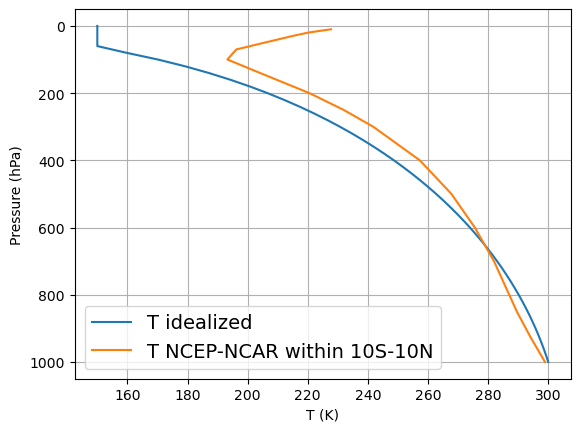

In [7]:
basic_state_skeleton['T'].sel(lat = slice(-10,10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T idealized')
basic_state.T.sel(lat = slice(10,-10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T NCEP-NCAR within 10S-10N')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('T (K)')
plt.ylabel('Pressure (hPa)')

In [8]:
vars = ['QDIAB', 'EHFD', 'EMFD_U', 'EMFD_V']
forcing_skeleton = xr.Dataset({var: (['pressure', 'lat', 'lon'], np.zeros((npres, nlat, 2*nlat-1))) for var in vars}, coords = {'pressure': np.linspace(0, 1e3, npres), 'lat': np.linspace(-90, 90, nlat), 'lon': np.linspace(-180, 180, 2*nlat-1)})
vars_sfc = ['ZSFC', 'SP']
for var in vars_sfc:
    forcing_skeleton[var] = (['lat','lon'], np.zeros((nlat, 2*nlat-1)))
forcing_skeleton['SP'][:] = ps * 1e2

In [11]:
lon = forcing_skeleton.lon; lat = forcing_skeleton.lat
dl = 10
lon0 = 90; lat0 = 30
lon_structure = np.exp( - (lon-lon0)**2 / 2 / dl**2)
lat_structure = np.exp( - (lat-lat0)**2 / 2 / dl**2)
forcing_skeleton['ZSFC'] = 10 * lat_structure * lon_structure

<GeoAxes: xlabel='lon', ylabel='lat'>

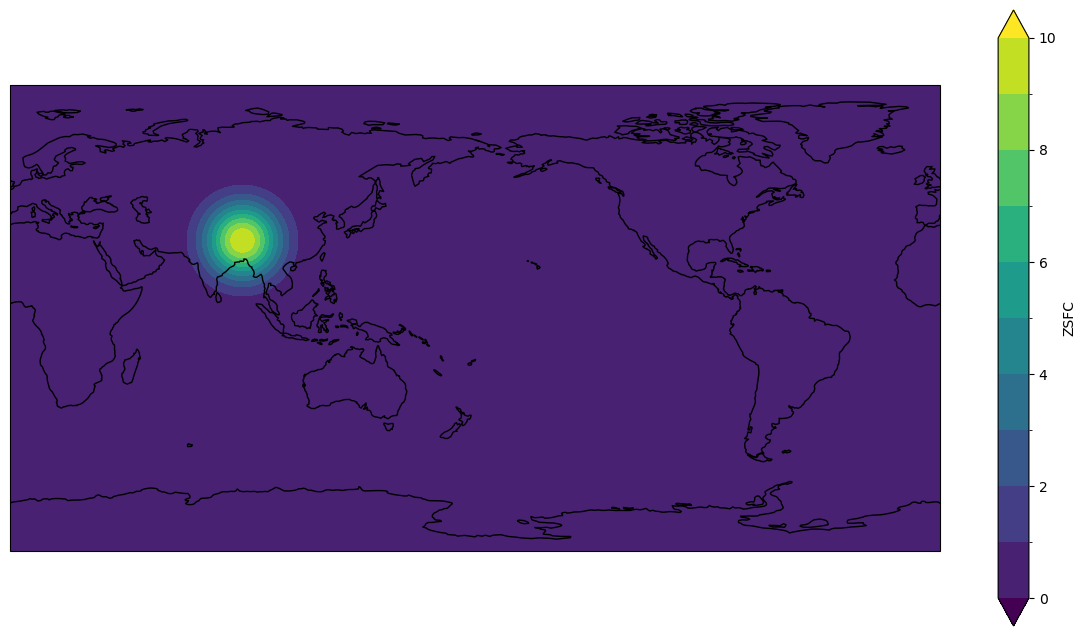

In [12]:
quickplot(forcing_skeleton['ZSFC'], levels=np.linspace(0, 10, 11), cmap='viridis')

In [ ]:
# basic_state_skeleton.to_netcdf('ideal_Gill_basic_state.nc')
forcing_skeleton.to_netcdf('ideal_topo_forcings.nc')

## Transform into Bill-compatible version

In [345]:
forcing_Gill = xr.open_dataset('ideal_Gill_forcings.nc')
forcing_Gill = lon_180_to_360(forcing_Gill['QDIAB'].rename(pressure='pre'))
forcing_Gill = wrap_lon(forcing_Gill).isel(lon=slice(1,None))
forcing_Gill.to_netcdf('ideal_Gill_QDIAB_forBill.nc')

In [ ]:
def adapt_basic_state(basic_state):
    """
    Transform the basic state to be compatible with Bill.
    """
    basic_state = basic_state.rename(pressure='pre')
    basic_state = basic_state.expand_dims({'lon':145}).assign_coords(lon=np.linspace(0,360,145)).transpose('pre','lat','lon')
    basic_state = basic_state.rename(U='u', V='v', W='w', T='t', SP='ps')
    basic_state['ps'] = basic_state.ps.expand_dims({'time':1})
    return basic_state

# basic_state_Gill = xr.open_dataset('ideal_Gill_basic_state.nc')
# basic_state_Gill['T'][:] = np.maximum(basic_state_Gill['T'].data,150)
# basic_state_Gill = adapt_basic_state(basic_state_Gill)
# basic_state_Gill.to_netcdf("ideal_Gill_basic_state_forBill.nc")

# Shallow water problem

In [53]:
snapshot_id = 'stationarywave_SW_T32_ideal_topo_nozm'
topo_SW_T32 = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)
topo_SW_T32_mean = topo_SW_T32.sel(t=slice(400,None)).mean('t').transpose('','latitude','longitude')
topo_SW_T32_mean = wrap_lon(topo_SW_T32_mean).isel(longitude=slice(1,None))

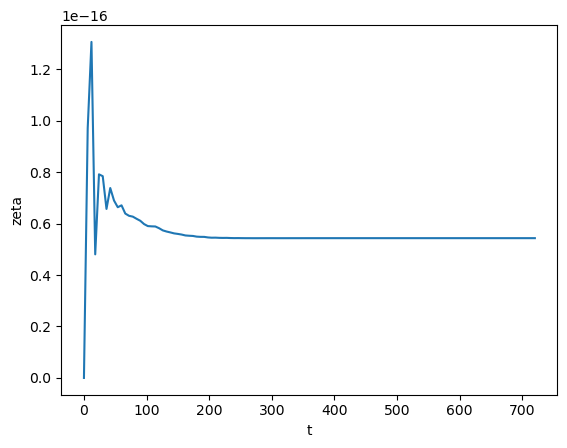

In [54]:
# Evolution of the mean enstrophy
(topo_SW_T32.zeta**2).mean(('latitude','longitude')).plot()

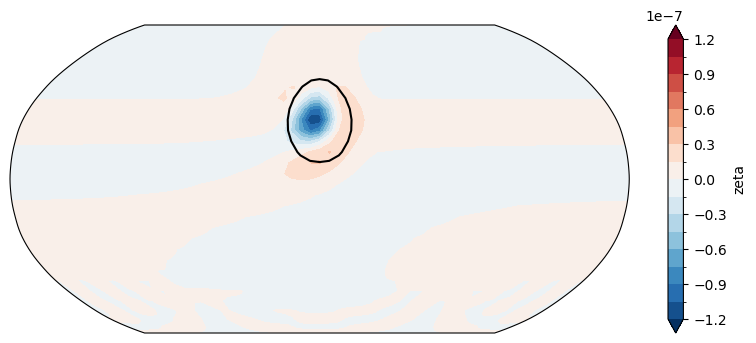

In [55]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
topo_SW_T32_mean.zeta.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
topo_SW_T32_mean.hbottom.plot.contour(ax=ax,levels=[0.1],colors=['k'],transform=ccrs.PlateCarree())


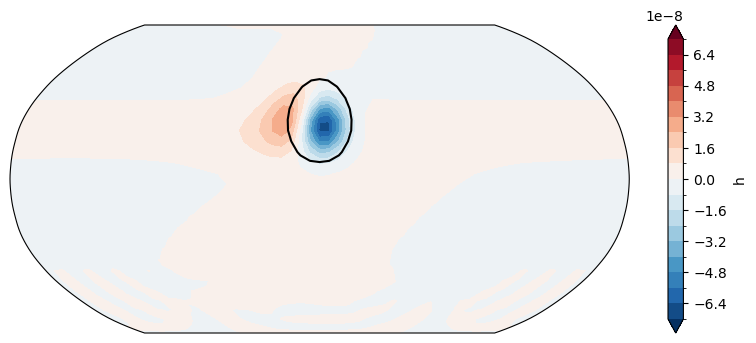

In [57]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
topo_SW_T32_mean.h.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
topo_SW_T32_mean.hbottom.plot.contour(ax=ax,levels=[0.1],colors=['k'],transform=ccrs.PlateCarree())


Text(0.5, 1.0, 'divergence, wind, and heating (black contour)')

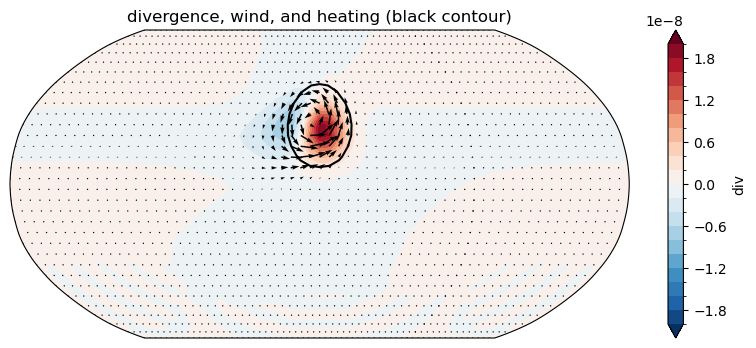

In [64]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
topo_SW_T32_mean.div.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
topo_SW_T32_mean.hbottom.plot.contour(ax=ax,levels=[0.1],colors=['k'],transform=ccrs.PlateCarree())

u= (topo_SW_T32_mean.u[0])
v=-(topo_SW_T32_mean.u[1])
n=1; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], -np.array(u)[::n,::m], -np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=1e-3)

plt.title('divergence, wind, and heating (black contour)')

# Full n-level model

In [18]:
ideal_T32 = process_sim('stationarywave_14level_T32_ideal_topo_nozm')
ideal_T32 = wrap_lon(ideal_T32).isel(longitude=slice(1,None))

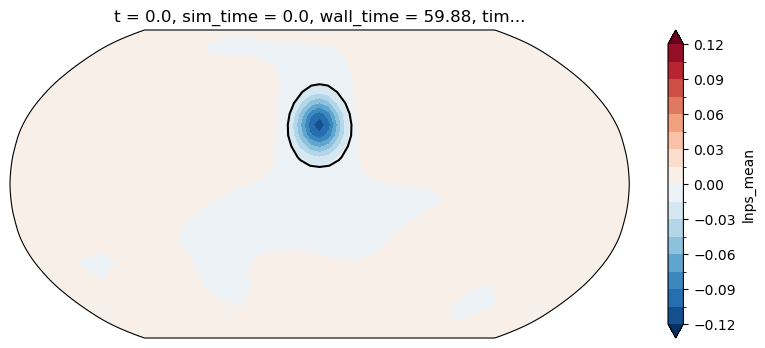

In [25]:
# Perturbation lnps in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
(1e2 * ideal_T32.lnps_mean).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
ideal_T32.Phisfc.isel(t=0).plot.contour(ax=ax,levels=[10],colors=['k'],transform=ccrs.PlateCarree())


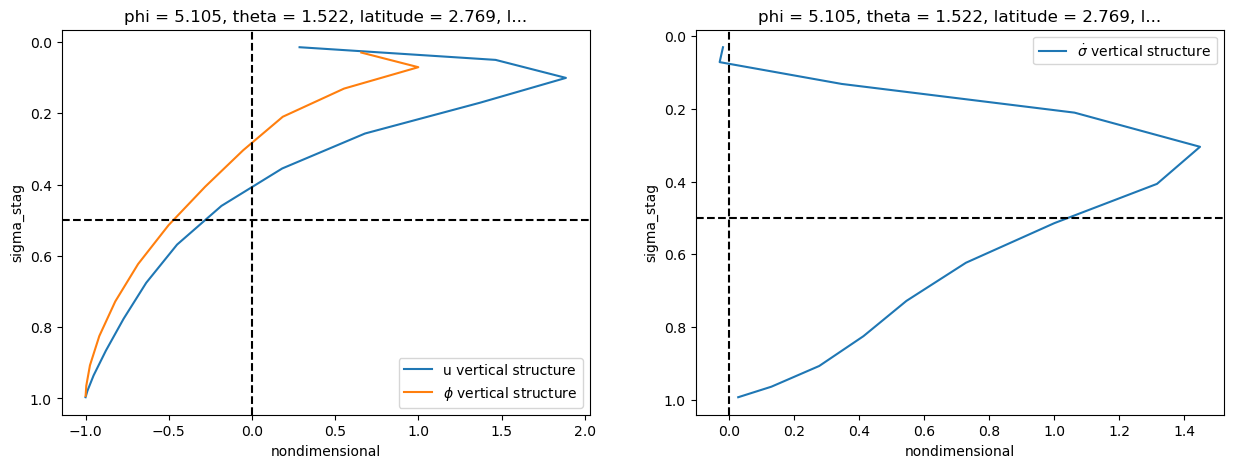

In [27]:
_,axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
(ideal_T32.u_mean[0]/(-ideal_T32.u_mean[0].isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',yincrease=False,label = 'u vertical structure')
Phiprime_test = ideal_T32.Phiprime_mean.sel(latitude = 0,longitude=110,method='nearest')
(Phiprime_test / Phiprime_test.max() * 2 - 1).plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\phi$ vertical structure')

ax = axs[1]
(ideal_T32.sigmadot_mean/(ideal_T32.sigmadot_mean.sel(sigma_stag=0.5,method='nearest'))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\dot \sigma$ vertical structure')

for ax in axs.flatten():
    ax.axvline(0., color='k', linestyle='--')
    ax.axhline(0.5, color='k', linestyle='--')
    ax.legend()
    ax.set_xlabel('nondimensional')

Text(0.5, 1.0, '$\\zeta(x,y,\\sigma=1)$ 14-level')

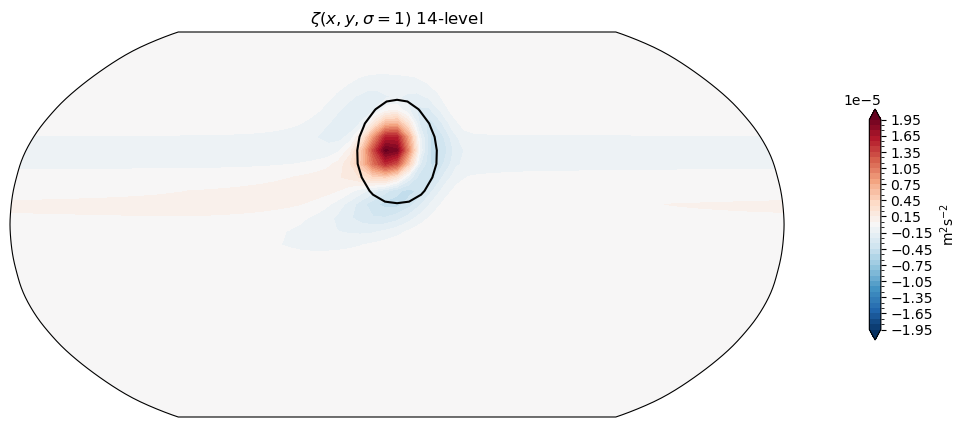

In [33]:
# Perturbation zeta in gill run
_,ax=plt.subplots(1,1,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
zeta_Nlev = 100 * (ideal_T32.zeta_mean).sel(sigma=1,method='nearest')
levs = np.linspace(-1.95,1.95,40) * 1e-5
zeta_Nlev.plot.contourf(ax=ax,levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

ideal_T32.Phisfc.isel(t=0).plot.contour(ax=ax,levels=[10],colors=['k'],transform=ccrs.PlateCarree())


ax.set_title(r'$\zeta(x,y,\sigma=1)$ 14-level')


Text(0.5, 1.0, '$\\phi(x,y,\\sigma=.5)$ 14-level')

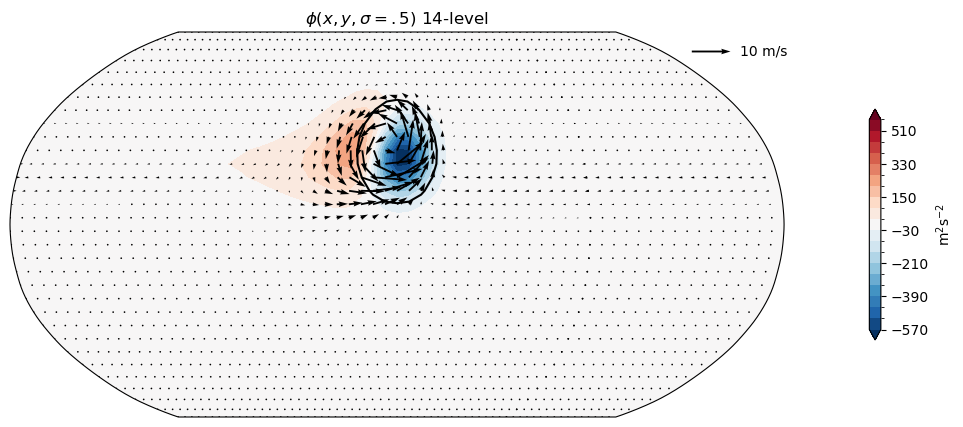

In [50]:
# Perturbation zeta in gill run
_,ax=plt.subplots(1,1,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
Phi_Nlev = 100 * (ideal_T32.Phiprime_mean).sel(sigma_stag=0.5,method='nearest')
levs = np.linspace(-1.9,1.9,20) * 3e2
Phi_Nlev.plot.contourf(ax=ax,levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

ideal_T32.Phisfc.isel(t=0).plot.contour(ax=ax,levels=[10],colors=['k'],transform=ccrs.PlateCarree())

add_wind(ax,100*ideal_T32.u_mean[0].sel(sigma=1,method='nearest'),-100*ideal_T32.u_mean[1].sel(sigma=1,method='nearest'),scale=200,keypos=(0.93,0.95),ref=10)

ax.set_title(r'$\phi(x,y,\sigma=.5)$ 14-level')


Text(0.5, 1.0, '$\\delta(x,y,\\sigma=1)$ 14-level')

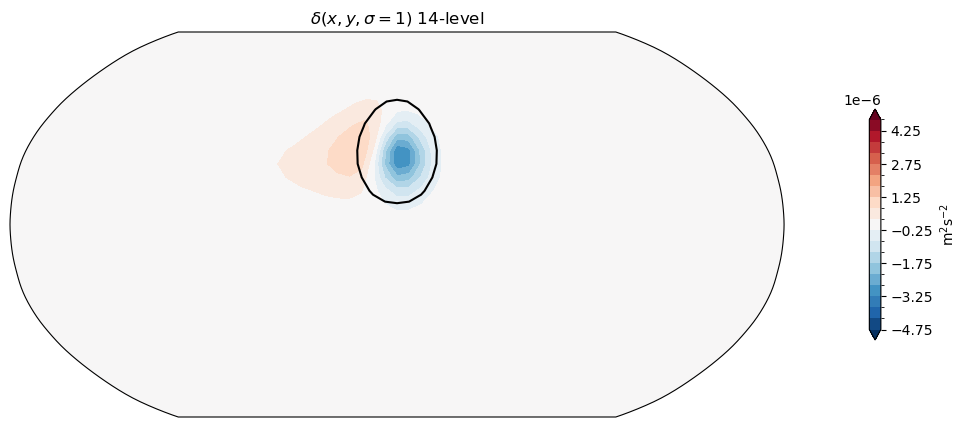

In [42]:
# Perturbation zeta in gill run
_,ax=plt.subplots(1,1,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
zeta_Nlev = 100 * (ideal_T32.div_mean).sel(sigma=1,method='nearest')
levs = np.linspace(-1.9,1.9,20) * 1e-5/4
zeta_Nlev.plot.contourf(ax=ax,levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

ideal_T32.Phisfc.isel(t=0).plot.contour(ax=ax,levels=[10],colors=['k'],transform=ccrs.PlateCarree())


ax.set_title(r'$\delta(x,y,\sigma=1)$ 14-level')


Text(0.5, 1.0, 'Difference 14lev - SW')

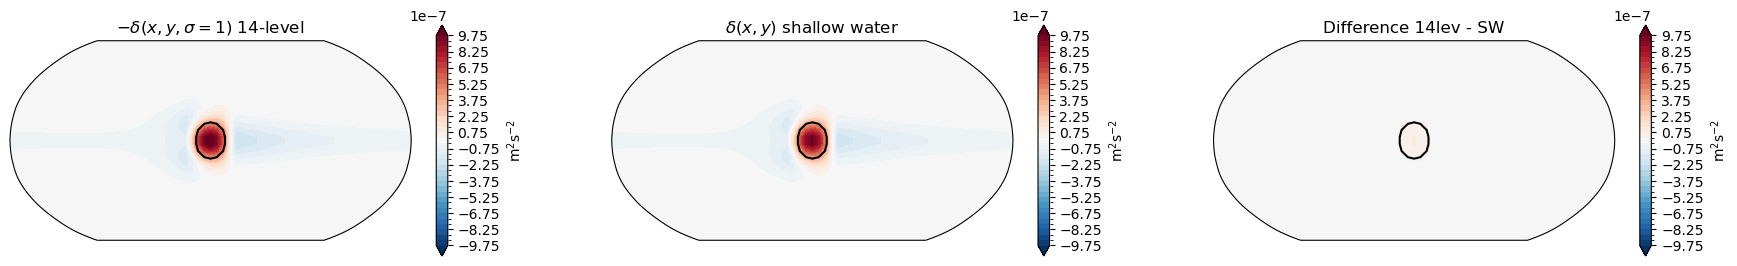

In [311]:
# Perturbation div in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
div_Nlev = 100 * (-ideal_T32.div_mean).sel(sigma=1,method='nearest')
div_SW = gill_SW_T32_mean.div
levs = np.linspace(-1.95,1.95,40) * 1e-6/2
div_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
div_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(div_Nlev - div_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$-\delta(x,y,\sigma=1)$ 14-level')
axs[1].set_title(r'$\delta(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

Text(0.5, 1.0, 'Difference 14lev - SW')

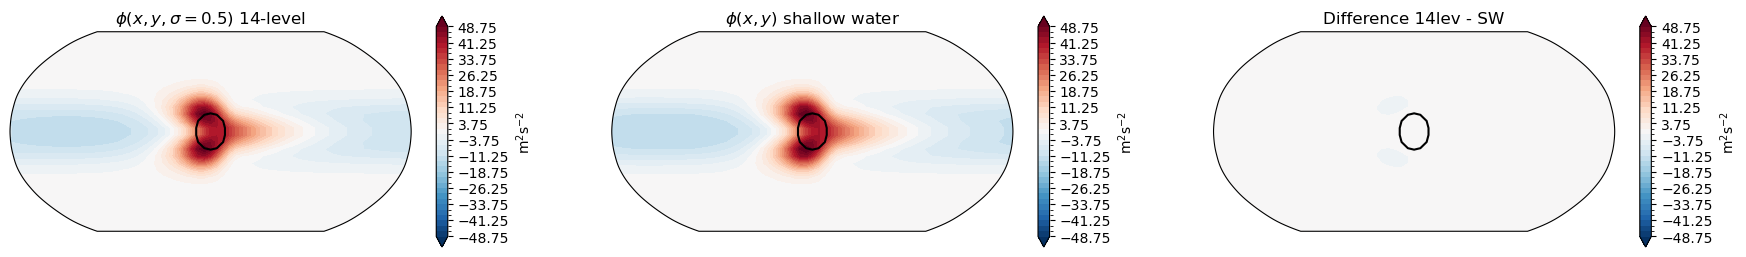

In [ ]:
# Perturbation phi in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
Phi_Nlev = 100 * (ideal_T32.Phiprime_mean).sel(sigma_stag=0.5,method='nearest')
Phi_SW = gill_SW_T32_mean.h * 9.81 * 6.37122e6
levs = np.linspace(-1.95,1.95,40) * 25
Phi_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
Phi_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(Phi_Nlev - Phi_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$\phi(x,y,\sigma=0.5)$ 14-level')
axs[1].set_title(r'$\phi(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()